In [1]:
from src.tilt_signal import Tilt2D, AngleMapping

from src.plot_utils import (plot_signals, plot_signals_roi, plot_signals_smoothing_pyramid, 
                        plot_points, color_mapping, plot_target_ymotion, plot_points_batched)

from src.plot_utils import plot_tan_theta, plot_tan_theta_all, plot_tan_theta_roi, plot_points_fusion

from src.data_utils import (read_recovery, read_repeat, filter_out_early_signals, 
    filter_out_late_signals, load_from_processed)

from src.backproj_solver import BackProjSolver
import copy
import os
import cv2

import numpy as np
import imageio 
import hdf5pickle

%matplotlib notebook
# %matplotlib inline
import matplotlib.pyplot as plt

def plot_list_func(y_list, label_list=None):
    
    x_list = list(range(len(y_list[0])))
    
    plt.figure()
    for i, y in enumerate(y_list):
        if label_list is not None:
            plt.plot(x_list, y, label=label_list[i])
        else:
            plt.plot(x_list, y)
            
    if label_list is not None:
        plt.legend()
    plt.show()

def reduce_camera_motion(signal_list):
    x_list = [_[0] for _ in signal_list]
    y_list = [_[1] for _ in signal_list]
    x_mean = np.stack(x_list, axis=0).mean(axis=0)
    y_mean = np.stack(y_list, axis=0).mean(axis=0)
    
    ret_signal_list = []
    
    for i in range(len(signal_list)):
        _signal = Tilt2D([signal_list[i][0] - x_mean, signal_list[i][1] - y_mean])
        ret_signal_list.append(_signal)
    
    return ret_signal_list

# Load Data

In [25]:

dir_path = "data/isotropic_plasticboard_20cm/"


npz_path = os.path.join(dir_path, 'processed_final.npz')

(all_signal_list, marker_locations, gt_locations_list, 
     gt_loc_list, name_list, DataDict) = load_from_processed(npz_path, len_first_clip=100, 
                                                             use_optical_scaling=True, shift_signal=False)

# transfer to gradient..
# new_all_signal_list = []
# for signal_list in all_signal_list:
#     new_all_signal_list.append([signal_.get_gradient(smoothing_wsize=6) for signal_ in signal_list])
# all_signal_list = new_all_signal_list

if 'corner_locations' in DataDict:
    corner_locations = DataDict['corner_locations']
else:
    corner_locations = None

marker_names = ["marker-{}".format(i) for i in range(len(marker_locations))]

# [tgt_ind, marker_ind]
gt_tan_list = []

for gt_loc in gt_loc_list:
    tmp_list = []
    for m_loc in marker_locations:
        den = m_loc[0] - gt_loc[0] + 1e-4
        nu = m_loc[1] - gt_loc[1]
        tmp_list.append(nu / den)
    gt_tan_list.append(tmp_list)

point_angle_list_list = []
for point_xy in gt_loc_list:
    angle_for_markers = []
    for marker_xy in marker_locations:
        diff_vec = point_xy - marker_xy
        theta = np.arctan2(diff_vec[1], diff_vec[0])
        angle_for_markers.append(theta)
    
    point_angle_list_list.append(angle_for_markers)
    

use_angle_mapping        = 1
if DataDict['angle_mapping_cfg'] is not None and use_angle_mapping:
    angle_map_cfg = DataDict['angle_mapping_cfg']
    angle_mapping_obj = AngleMapping(DataDict['angle_mapping_cfg'])
else:
    angle_mapping_obj = AngleMapping()
    
print(angle_mapping_obj.params_list)

# replicate angle config
# DataDict['angle_mapping_cfg']["params"] = np.concatenate(
#      [DataDict['angle_mapping_cfg']["params"], DataDict['angle_mapping_cfg']["params"]], axis=0)
# angle_mapping_obj = AngleMapping(DataDict['angle_mapping_cfg'])

=> Loading
Signal X of shape : (21, 5, 1808)
Names:  ['point-13' 'point-14' 'point-15' 'point-14' 'point-16' 'point-16'
 'point-15' 'point-12' 'point-18' 'point-17' 'point-14' 'point-17'
 'point-13' 'point-13' 'point-18' 'point-12' 'point-12' 'point-18'
 'point-15' 'point-16' 'point-17']
[[ 0.99840898 -0.0230286 ]
 [ 0.99840898 -0.0230286 ]
 [ 0.99840898 -0.0230286 ]
 [ 0.99840898 -0.0230286 ]
 [ 0.99840898 -0.0230286 ]]


## Plot the spatial arrangement of the points

<IPython.core.display.Javascript object>


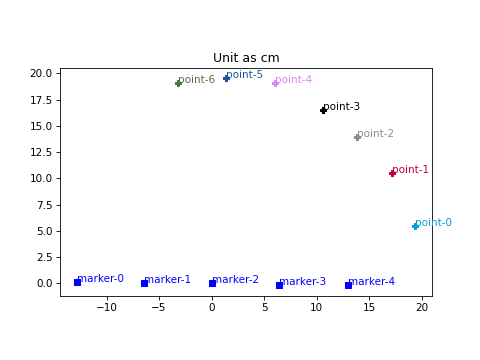

=> marker locations: 
[[-12.82, 0.1], [-6.41, 0.07], [0.0, 0.0], [6.41, -0.11], [13.01, -0.18]]
=> gt locations: 
[[19.38, 5.44], [17.16, 10.54], [13.88, 13.96], [10.65, 16.49], [6.08, 19.05], [1.36, 19.53], [-3.21, 19.12]]
distance from target to center:  [20.12642974 20.13579591 19.68797839 19.6308126  19.9993588  19.58215417
 19.3853423 ]


In [26]:
### Plot the arrangement
plot_marker_inds = []

plt.figure()
plt.title('Unit as cm')
for i, mxy in enumerate(marker_locations):
    label='marker-{}'.format(i)
    m_color = 'blue'
    
    if i in plot_marker_inds:
        plt.scatter([mxy[0]], mxy[1], color='blue', label=label, marker='s')
        plt.text(mxy[0], mxy[1], s=label, color='blue')
    else:
        
        plt.scatter([mxy[0]], mxy[1], color=m_color, label=label, marker='s')
        plt.text(mxy[0], mxy[1], s=label, color=m_color)

for i, txy in enumerate(gt_loc_list):
    
    if name_list is not None and i < len(name_list):
        label = name_list[i]
    else:
        label = 'knock-{}'.format(i)
    
    label = 'point-{}'.format(i)
    
    plt.scatter([txy[0]], [txy[1]], color=color_mapping[i], label=label, marker='P')
    plt.text(txy[0], txy[1], s=label, color=color_mapping[i])
    

ax = plt.gca() #
ax.set_aspect('equal')

# ax.invert_yaxis()
# plt.grid(True, which='both')

# plt.axhline(y=0, color='k')
# plt.axvline(x=0, color='k')    
plt.show()

# plt.ylim([-15, 8])
# plt.xlim([-28, 28])

print('=> marker locations: ')
print(np.round(marker_locations, 2).tolist())
print('=> gt locations: ')
print(np.round(gt_loc_list, 2).tolist())


r_array = np.array(gt_loc_list)
r_array = np.sqrt(np.sum( (r_array ** 2), axis=-1))
print('distance from target to center: ', r_array)

# Visualize the signals

=> showing 2/3 signal


<IPython.core.display.Javascript object>


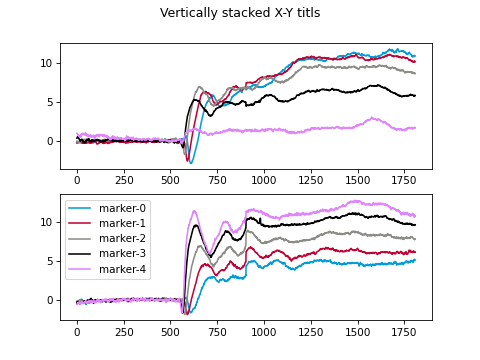

<IPython.core.display.Javascript object>


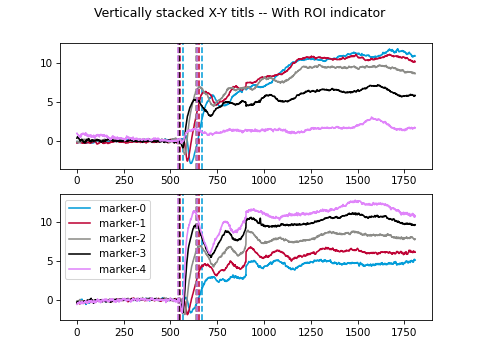

=> start frame for marker-0 is: 567
=> start frame for marker-1 is: 553
=> start frame for marker-2 is: 539
=> start frame for marker-3 is: 544
=> start frame for marker-4 is: 541


<IPython.core.display.Javascript object>


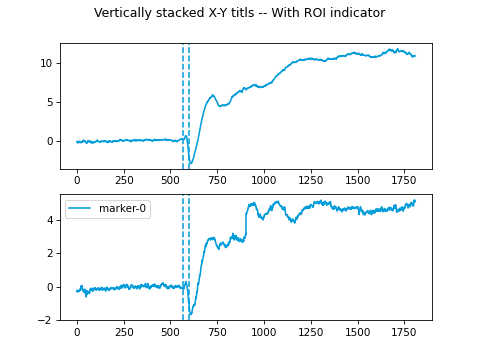

=> start frame for marker-0 is: 567
gt_tan_theta:  [ 0.52  0.68  1.01  1.88 16.17]


In [27]:
tgt_ind      = 2 # point index
exp_index    = 1 # which experiment 

# how many markers you want to show? 
marker_inds = [0,1,2,3,4]
m_location = [marker_locations[i] for i in marker_inds]

# mar_names = [marker_names[i] for i in marker_inds]
mar_names = ['marker-{}'.format(i) for i in marker_inds]

signal_list_list = []
for i in range(len(all_signal_list)):
    dist_ = (gt_loc_list[tgt_ind] - gt_locations_list[i]) ** 2
    
    dist_ = np.sum(dist_)
    if dist_ < 1e-1:
        signal_list_list.append([all_signal_list[i][m_ind] for m_ind in marker_inds])

# append algined siganl


align_cfg = {'if_normalize': False, 'offset': 0, 'thre': -0.03, 
             'std_coe': 10.0, 'smoothing_wsize': -1, 'window_size': 20}
# align signal
# avg_signal_list, aligned_signal_list_list = align_and_fuse_signal(signal_list_list, align_cfg, 
#                                                                   offset=-100, window_size=350)  
# signal_list_list.append(avg_signal_list)

start_cfg = {
'std_coe': 20, 'smoothing_wsize':8, 'forward_window_size': 40,}
                 # "stability_window_size": 20, "stability_temperature": 100,}

print("=> showing {}/{} signal".format(exp_index + 1, len(signal_list_list)))        
signal_list = signal_list_list[exp_index]

# for i in range(len(signal_list)):
#     signal_list[i].tilt_y = signal_list[i][1] * -1.0

pred_start_index_list = [
    signal_.get_start_index(**start_cfg) for signal_ in signal_list
                        ]

plot_signals(signal_list, label_list=mar_names, start_index_list=pred_start_index_list, window_size=100)

show_ind = 0
plot_signals([signal_list[show_ind]], 
             start_index_list=[pred_start_index_list[show_ind]], if_double_plot=False)


print('gt_tan_theta: ', np.round(gt_tan_list[tgt_ind], 2))

# -------------- Visualize All repeat ---------------- #
# plot_signals([signal_list_list[0][show_ind], 
#               signal_list_list[1][show_ind],
#               signal_list_list[2][show_ind],
#               signal_list_list[3][show_ind],
#               # signal_list_list[4][show_ind],
#               # signal_list_list[5][show_ind],
#               ],
#              label_list=['exp-0', 'exp-1', 'exp-2', 'exp-3', 'exp-4', 'exp-5'])


# -------------- Visualize Signal Aligment ---------------- #
# plot_signals([aligned_signal_list_list[0][show_ind], 
#               aligned_signal_list_list[1][show_ind],
#               aligned_signal_list_list[2][show_ind],
#               signal_list_list[-1][show_ind]],
#              label_list=['exp-0', 'exp-1', 'exp-2', 'fuse'])

# start_index_list = [[475, 475, 475, 475, 475]]
# start_index_list = [[230, 230, 230, 230, 230]]

# Localization through the backprojection

In [17]:
drawing_cfg=dict(
    name="line",
    thickness=8,
    weighting_by_scale=False, #'sqrt', #'log',
    weighting_by_distance=False, #"sqrt",
    # weighting_by_scale=False,
    # weighting_by_distance=False #"sqrt",
)


drawing_cfg=dict(
    name="cone",
    fov=12,
    thickness=-1,
    weighting_by_scale=False, #'log', #'sqrt', #'sqrt', # 'sqrt', #'log', #'sqrt', #'sqrt', #'sqrt', #'log',
    weighting_by_uncertainty=False,
)

drawing_cfg=dict(
    name="weighted_cone",
    fov=6,
    thickness=-1,
    weighting_by_scale=False, #'log', #'sqrt', #'sqrt', # 'sqrt', #'log', #'sqrt', #'sqrt', #'sqrt', #'log',
    weighting_by_uncertainty=False,
    cone_weighting=0.04,
)


proj_theta_cfg=dict(
            std_coe=15.0,
            smoothing_wsize=8,
            stability_window_size_start=-1, 
            forward_window_size=40,
            stability_temperature=150,
            if_normalize=False,
            start_index=-1, # None
            offset=20,
            thre=-1.0,
            window_size=120,
            stability_window_size=100,
            yscaling=1.0,
            drawing_cfg=drawing_cfg,
            pre_size=10,
            safe_interval=10,
            weighting_cfg={'name': 'poly', 'params': [1.0]},  # Linear backprojection, no filtering
            global_start=False,
        )

marker_scaling = 12 # scale the canvas size by 12. 

# whiteboard_corner = np.array([[-22, 22], [22, -2]])

proj_solver = BackProjSolver(m_location, marker_scaling=12, canvas_size=[700, 700], 
                             angle_mapping_obj=angle_mapping_obj, theta_cfg=proj_theta_cfg, 
                             corner_locations=None, marker_offset=[0, -200], marker_center=np.array([0, 0]))

    
save_path_ = os.path.join(dir_path, 'point:{}-exp:{}-pred.png'.format(tgt_ind, exp_index))

start_time_list_list = [[], [1400]*5,  [1100]*5]

[0 0]
corner locations on canvas. tl. br
None


In [19]:
# specify the starting time of the stable period by changing this variables 
hand_start_index_list = None # [120, 120, 120, 120, 120] 

pred_xy, heat_map, plot_marker_locations, plot_pred_xy, img_gt_loc = proj_solver.pred_and_plot_polish(signal_list, gt_loc=gt_loc_list[tgt_ind], debug=True, 
                          start_index_list=hand_start_index_list ) 
plt.tight_layout()


gt_loc = gt_loc_list[tgt_ind]

mse = np.sqrt( ((gt_loc - pred_xy) ** 2).sum())
print('MSE: {:.2f}'.format(mse))


[565 552 538 542 540]


<IPython.core.display.Javascript object>

MSE: 18.29


## Batched Prediction

In [20]:
## --------- Target Selection ------------------ ##
plot_list = [1,2,3,4,5,6]
## --------------------------------------------- ##

all_pred_list_list = []
all_gt_list = []
mse_list = []

save_dir = os.path.join(dir_path, 'tmp')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

save_path_list = []

img_ind = 0

final_pred_list = []
plot_gt_list = []
mse_list = []

for tgt_ind in plot_list:  # point index

    signal_list_list = []
    for i in range(len(all_signal_list)):
        dist_ = (gt_loc_list[tgt_ind] - gt_locations_list[i]) ** 2

        dist_ = np.sum(dist_)
        if dist_ < 1e-1:
            signal_list_list.append([all_signal_list[i][m_ind] for m_ind in marker_inds])
    
    if len(signal_list_list) == 0:
        print('point-{} no data'.format(tgt_ind))
    # append algined siganl

#     if tgt_ind not in no_align_list:
#         theta_cfg_align = {'if_normalize': True, 'offset': 0, 'thre': -0.03, 
#              'angle_config': {'name': 'soft_l1_nobias'}, 
#              'std_coe': 10.0, 'smoothing_wsize': -1, 'window_size': 20}
#         avg_signal_list, aligned_signal_list_list = align_and_fuse_signal(signal_list_list, theta_cfg_align, offset=-30)  
#         signal_list_list.append(avg_signal_list)

    all_gt_list.append(gt_loc_list[tgt_ind])
    
    final_pred_list = []
    plot_gt_list = []
    for i, _signal_list in enumerate(signal_list_list):
        
        if i > 10:
            pass
        
        start_index_list = None
        
        save_path = os.path.join(save_dir, '{}.png'.format(img_ind))
        img_ind += 1
        save_path_list.append(save_path)
        # pred_xy = proj_solver.pred_and_plot(_signal_list, gt_loc=gt_loc_list[tgt_ind], save_path=save_path)
        pred_xy, ret_img = proj_solver.pred(_signal_list, debug=False)
        
        
        final_pred_list.append(pred_xy)
        plot_gt_list.append(gt_loc_list[tgt_ind])

    
    mse = np.array(final_pred_list) - np.array(plot_gt_list)
    
    mse_list.append(np.sqrt( np.sum(mse ** 2, axis=-1)))
    mse = np.sqrt( np.sum(mse ** 2, axis=-1)).mean()
    print("MSE: {:.3f}".format(mse))
    
    
    all_pred_list_list.append(final_pred_list)
    
plot_points_fusion(m_location, source_locations=all_gt_list, pred_locations=all_pred_list_list)


final_mse = np.concatenate(mse_list)
print('Num signal: {} -- Final Mse: {:.3f}'.format(final_mse.shape[0], np.mean(final_mse)))
        

# plt.xlim([-15, 35])
# plt.ylim([-5, 40])
    
# plt.xlim([-15, 25])
# plt.ylim([-5, 25])

Frame ind exceds length, start list:  [1776, 1776, 1776, 1776, 1776]
MSE: 2.053
MSE: 1.676
MSE: 1.208
MSE: 0.691
MSE: 0.419
MSE: 0.822


<IPython.core.display.Javascript object>

Num signal: 18 -- Final Mse: 1.145


# Material Caliberation

## Compute Stable ratios for all measurements

In [29]:
pred_func_name="soft_l1"
pred_func_cfg={}

theta_cfg_ana = {'if_normalize': True, 'offset': 0, 'thre': -0.03, 
                 'angle_config': {'name': 'soft_l1_nobias'}, 
                 'std_coe': 20.0, 'smoothing_wsize':8, 'forward_window_size': 50,
                 "stability_window_size": -1, "stability_temperature": 100,
                 'window_size': 70, 
                 'pre_size': 10, 'safe_interval': 10,   
                 "search_range": [30, 100, 2]}
    
save_marker_inds = [0,1,2,3,4]
# [point_ind][repeat_index][marker_index]
pred_tan_theta_list_list      = []
optimized_error_list_list     = []
flatten_error_list            = []

for pnt_ind in range(len(gt_loc_list)):  # point index

    signal_list_list = []
    for i in range(len(all_signal_list)):
        dist_ = (gt_loc_list[pnt_ind] - gt_locations_list[i]) ** 2

        dist_ = np.sum(dist_)
        if dist_ < 1e-1:
            signal_list_list.append(all_signal_list[i])
    
    
    pred_tan_theta_list = []
    error_list          = []
    
    if len(signal_list_list) == 0:
        pred_tan_theta_list_list.append(pred_tan_theta_list)
        optimized_error_list_list.append(error_list)
        continue
    
    for i, _signal_list in enumerate(signal_list_list):
        
        tmp_list       = []
        tmp_error_list = []
        for mind in save_marker_inds:
            _signal   = _signal_list[mind]
            ret       = _signal.get_theta(**theta_cfg_ana)
            pred_tan  = ret[0]
            min_error = ret[1][0]


            tmp_list.append(pred_tan)
            tmp_error_list.append(min_error)
            flatten_error_list.append(min_error)
        
        pred_tan_theta_list.append(tmp_list)
        error_list.append(tmp_error_list)
    
    pred_tan_theta_list_list.append(pred_tan_theta_list)
    optimized_error_list_list.append(error_list)

## Visualize the error distribution

<IPython.core.display.Javascript object>


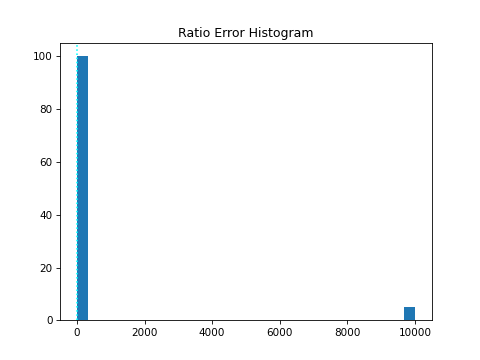

<IPython.core.display.Javascript object>


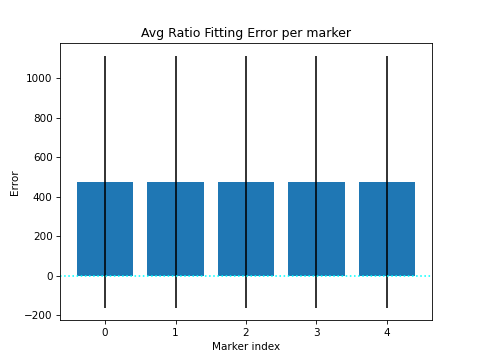

In [33]:
##### ------------- #####
# We visualize the error for fitting stable ratios over the stable periods
# since the computation invovles division, there might be some very large error
# noisy signals, or divid_zero signals will be filtered out later

##### ------------- #####


error_list_per_marker = [[], [], [], [], []]
for pnt_ind in range(len(pred_tan_theta_list_list)):
    for rep_ind in range(len(pred_tan_theta_list_list[pnt_ind])):
        for m_ind in range(5):
            error_list_per_marker[m_ind].append(optimized_error_list_list[pnt_ind][rep_ind][m_ind])

error_variance_per_mar = [np.std(np.array(_)) * 0.3 for _ in error_list_per_marker]  
error_list_per_marker = [np.array(_).mean() for _ in error_list_per_marker]            

# error threshould for removing noisy or divided-zero signals
ratio_error_thres = np.percentile(np.array(flatten_error_list), 70)

plt.figure()
plt.title('Ratio Error Histogram')
plt.hist(flatten_error_list, bins=30)

plt.axvline(x=ratio_error_thres, linestyle='dotted', color='cyan')
plt.show()



plt.figure()
plt.title('Avg Ratio Fitting Error per marker')
plt.xlabel('Marker index')
plt.ylabel('Error')
plt.bar(list(range(5)), error_list_per_marker, yerr=error_variance_per_mar)
plt.axhline(y=ratio_error_thres, linestyle='dotted', color='cyan')
plt.show()



## Plot computed stable ratios

In [34]:
##### ------------- #####
# Preprocess the pre-computed stable ratios, 
# 1. add filtering
# 2. pair the (computed_stable_ratio,  tan(angle of arrival))

##### ------------- #####

def unfold_list_of_array(array_list, reduction=None):
    """
    Args:
        array_list: List[np.ndarray].  length may vary
        reduction: in ['mean', None]
    """
    
    ret_list = [] 
    num_array = len(array_list)

    for i in range(num_array):
        tmp_array = array_list[i]
        
        if len(tmp_array) < 1:
            continue
        
        if reduction == 'mean':
            ret_list.append(np.mean(tmp_array))
        elif reduction == None:
            ret_list += tmp_array.tolist()
    
    return ret_list
        
        
use_hand_theta = 0
if use_hand_theta:

    for i in range(len(pred_tan_theta_list_list_hand)):
        pred_list = pred_tan_theta_list_list_hand[i]
        for rep_ind in range(len(pred_list)):
            for m_ind in range(len(pred_list[rep_ind])):
                pred_tan_theta_list_list[i][rep_ind][m_ind] = pred_tan_theta_list_list_hand[i][rep_ind][m_ind] 

plot_marker_ind_list = [0, 1,2,3,4]

plot_tgt_ind_list = list(range(len(pred_tan_theta_list_list))) # I remove 4
# plot_tgt_ind_list = [0,1,2,3,4,5, 6, 7] # I remove 4

plot_pred_tan_list = []
plot_gt_tan_list = []
plot_gt_theta_list = []
plot_m_ind_list = [] # used to identify different scaling for different marker

do_average = True
filtering_by_error_thres = True

remove_small_sample = False

reduction = None
if do_average:
    reduction = 'mean'

for pnt_ind in plot_tgt_ind_list:
    if not (i in [0,1,2,3,4,5,6,7]):
            pass
    # if not (pnt_ind in [7, 8]):
    #     continue
    
    # for five markers
    rep_pred_list = [[], [], [], [], []]
    rep_gt_tan_list = [[], [], [], [], []]
    rep_gt_theta_list = [[], [], [], [], []]
    rep_marker_ind_list = [[], [], [], [], []]
    
    if remove_small_sample:
        if len(pred_tan_theta_list_list[pnt_ind]) < 2:
            continue
    for rep_ind in range(len(pred_tan_theta_list_list[pnt_ind])):
        
        for m_ind in plot_marker_ind_list:
            if len(pred_tan_theta_list_list[pnt_ind][rep_ind]) == 0:
                continue
            ratio_error = optimized_error_list_list[pnt_ind][rep_ind][m_ind]
            pred_tan = pred_tan_theta_list_list[pnt_ind][rep_ind][m_ind]
            
            if filtering_by_error_thres and ratio_error > ratio_error_thres:
                # print('remove measurement with large ratio error')
                continue
            
            if (np.isnan(pred_tan)):
                print('nan encountered')
                continue
            
            if pred_tan is None or (np.abs(pred_tan) > 8):
                # print(gt_tan_list[pnt_ind][m_ind], pred_tan, pnt_ind, m_ind)
                continue
            if pred_tan is None or (gt_tan_list[pnt_ind][m_ind] < -1.5):
                # print(gt_tan_list[pnt_ind][m_ind], pred_tan, pnt_ind, m_ind)
                pass
            if np.abs(gt_tan_list[pnt_ind][m_ind]) > 5:
                # print(gt_tan_list[pnt_ind][m_ind], pnt_ind, m_ind)
                continue

            rep_pred_list[m_ind].append(pred_tan)

            rep_gt_tan_list[m_ind].append(gt_tan_list[pnt_ind][m_ind])

            # plot_gt_theta_list.append( np.rad2deg(point_angle_list_list[pnt_ind][m_ind]))
            rep_gt_theta_list[m_ind].append( point_angle_list_list[pnt_ind][m_ind])
            
            rep_marker_ind_list[m_ind].append(m_ind)
    
    rep_pred = [np.array(_) for _ in rep_pred_list]
    rep_gt_tan = [np.array(_) for _ in rep_gt_tan_list]
    rep_gt_theta = [np.array(_) for _ in rep_gt_theta_list]
    rep_marker_ind = [np.array(_, dtype=np.int32) for _ in rep_marker_ind_list]
    
    rep_pred = unfold_list_of_array(rep_pred, reduction)
    rep_gt_tan = unfold_list_of_array(rep_gt_tan, reduction)
    rep_gt_theta = unfold_list_of_array(rep_gt_theta, reduction)
    rep_marker_ind = unfold_list_of_array(rep_marker_ind, reduction)
    rep_marker_ind = [int(_) for _ in rep_marker_ind]
        
    plot_pred_tan_list += rep_pred
    plot_gt_tan_list += rep_gt_tan
    plot_gt_theta_list += rep_gt_theta
    plot_m_ind_list  += rep_marker_ind
# print(plot_gt_tan_list, plot_pred_tan_list)
print(len(plot_gt_tan_list), len(plot_pred_tan_list))
# print(plot_gt_tan_list, plot_pred_tan_list)
plot_color_list = [color_mapping[i] for i in plot_m_ind_list]

29 29


<IPython.core.display.Javascript object>


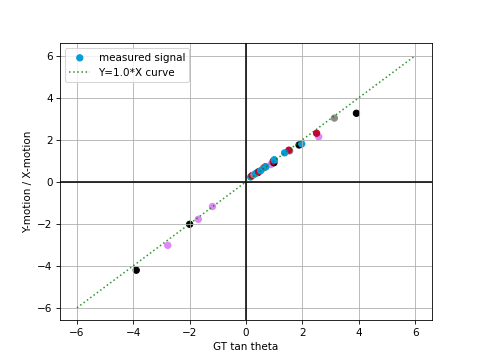

Optimization terminated successfully.
         Current function value: 0.106720
         Iterations: 34
         Function evaluations: 68
Scaling median: 1.015 -- 1.006
L1: 0.107 -- Scaled L1: 0.107


In [32]:
##### ------------- #####
# plot the paired (computed_stable_ratio,  tan(angle of arrival))
# plot the best-fitted-line.  the slope of this line is the material anisotropy

##### ------------- #####

from scipy.optimize import least_squares, minimize
plt.figure()
plt.xlabel('GT tan theta')
plt.ylabel('Y-motion / X-motion')
# plt.xlim([0, 2])
# plt.ylim([0, 2])

# plt.ylim([-16, 16])

ax = plt.gca() #
# ax.set_aspect('equal')

plt.grid(True, which='both')

plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.scatter(plot_gt_tan_list, plot_pred_tan_list, label='measured signal', color=plot_color_list)

scale_median = np.median( np.array(plot_pred_tan_list) / np.array(plot_gt_tan_list))


scale_ = 1.0
linear_x = np.linspace(-6, 6, 10)
linear_y = linear_x * scale_
plt.plot(linear_x, linear_y, color='green', alpha=0.8, linestyle='dotted', label='Y={}*X curve'.format(scale_))

# plt.scatter(np.array(plot_gt_tan_list) * -1.0, np.array( plot_pred_tan_list) * -1.0, alpha=0.5, label='symmetry across 0')
plt.legend()
plt.show()

mse = np.array(plot_gt_tan_list) - np.array(plot_pred_tan_list)

def linear_scaling_cost(param, pred_list, gt_list):
    k = param[0]
    
    loss = np.abs(pred_list / k - gt_list).mean()
    return loss
    
linear_params = np.array([1.0])

linear_res = minimize(linear_scaling_cost, linear_params,  method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True}, 
        args=(np.array(plot_pred_tan_list), np.array(plot_gt_tan_list)),
              bounds=[[-20, 40.0]])


scaled_mse = np.array(plot_gt_tan_list) * linear_res.x[0] - (np.array(plot_pred_tan_list))
print('Scaling median: {:.3f} -- {:.3f}'.format(scale_median, linear_res.x[0]))

print('L1: {:.3f} -- Scaled L1: {:.3f}'.format(np.abs(mse).mean(), np.abs(scaled_mse).mean() ))


# Pingpong Demo